## This notebook is used for camera hexapod endurance

Step-by-step description of what we do can be found in 
Jira test case: https://jira.lsstcorp.org/secure/Tests.jspa#/testCase/LVV-T???? 

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from lsst.ts import salobj
import asyncio
import os

import numpy as np
from matplotlib import pyplot as plt
from astropy.time import Time
from datetime import datetime, timedelta
import pandas as pd

from lsst.ts.observatory.control.maintel.mtcs import MTCS, MTCSUsages
from lsst.ts.observatory.control import RotType
from astropy.coordinates import AltAz, ICRS, EarthLocation, Angle, FK5
import astropy.units as u

from aosTools import *

plt.jet();

<Figure size 432x288 with 0 Axes>

In [3]:
print(os.environ["OSPL_URI"])
print(os.environ["LSST_DDS_PARTITION_PREFIX"])
print(os.environ["LSST_DDS_DOMAIN_ID"])

file:///home/bxin/WORK/ts_ddsconfig/config/ospl-shmem.xml
summit
0


In [4]:
#index is an integter which helps avoid multple users starting same controller
script = salobj.Controller("Script", index=7)

In [14]:
mtcs = MTCS(script.domain)
mtcs.set_rem_loglevel(40)

electrical DDS read queue is filling: 71 of 100 elements
electrical DDS read queue is full (100 elements); data may be lost
application DDS read queue is filling: 73 of 100 elements
timeAndDate DDS read queue is full (100 elements); data may be lost
powerSupplyData DDS read queue is full (100 elements); data may be lost
application DDS read queue is full (100 elements); data may be lost
actuators DDS read queue is filling: 73 of 100 elements
inclinometerData DDS read queue is full (100 elements); data may be lost
actuators DDS read queue is full (100 elements); data may be lost
imsData DDS read queue is full (100 elements); data may be lost
hardpointMonitorData DDS read queue is full (100 elements); data may be lost
hardpointActuatorData DDS read queue is full (100 elements); data may be lost
forceActuatorData DDS read queue is full (100 elements); data may be lost
accelerometerData DDS read queue is full (100 elements); data may be lost


In [15]:
await mtcs.start_task

[None, None, None, None, None, None, None, None, None, None]

In [13]:
await mtcs.close()

In [87]:
mtcs.components_attr

['mtmount',
 'mtptg',
 'mtaos',
 'mtm1m3',
 'mtm2',
 'mthexapod_1',
 'mthexapod_2',
 'mtrotator',
 'mtdome',
 'mtdometrajectory']

In [88]:
camhex = mtcs.rem.mthexapod_1
mount = mtcs.rem.mtmount

In [10]:
def printLogMessage(data):
    print(f"{data.level}: {data.message}")
camhex.evt_logMessage.callback = printLogMessage
await camhex.cmd_setLogLevel.set_start(level=10, timeout=5)

In [18]:
summit = 1 #use this for summit testing
#summit = 0 #use this for NCSA

In [19]:
from lsst_efd_client import EfdClient

if summit:
    client = EfdClient('summit_efd')
else:
    client = EfdClient('ncsa_teststand_efd')
csc_index = 1

### Get cam hex Ready: check config; make sure LUT is on, and has valid inputs; make sure hex is at LUT position

In [118]:
await camhex.evt_heartbeat.next(flush=True, timeout=5)

In [115]:
await readyHexaForAOS(camhex)

settingsVersion =  default.yaml:v0.7.2-0-g4375e27 2021-05-04 15:54:36.967497472
pivot at (0, 0, -2758400) microns 
maxXY =  11400.0 microns, maxZ=  13100.0  microns
maxUV =  0.36 deg, maxW=  0.1  deg
compsensation mode enabled? True 2021-05-05 19:40:34.026788608
hexapod already at LUT position
hexapod already at LUT position
Uncompensated position
      0.00       0.00       0.00      0.000000   0.000000   0.000000    2021-05-05 19:40:35.938602752
Compensated position
     -0.88    -469.52     288.06      -0.012831   0.000000   0.000000    2021-05-05 21:12:23.552271616
Does the hexapod has enough inputs to do LUT compensation? (If the below times out, we do not.)
mount elevation =  82.025784
mount azimth =  0.0
rotator angle =  0.0
? temperature =  0.0
x,y,z,u,v,w =  -0.8841103157072503 -469.51853502156416 288.05966252489463 -0.012831134662683673 0.0 0.0 2021-05-05 21:12:23.552463616


In [25]:
await salobj.set_summary_state(camhex, salobj.State.STANDBY)

[<State.STANDBY: 5>]

In [ ]:
await camhex.cmd_exitControl.set_start(timeout=10.)

In [78]:
await salobj.set_summary_state(camhex, salobj.State.ENABLED, settingsToApply="default")

[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]

In [119]:
state = await camhex.evt_summaryState.aget(timeout=5)
print('staring with: cam hex state', salobj.State(state.summaryState), pd.to_datetime(state.private_sndStamp, unit='s'))
dstate = await camhex.evt_controllerState.aget(timeout=5)
print('          cam hex state', MTHexapod.EnabledSubstate(dstate.enabledSubstate), 
  pd.to_datetime(dstate.private_sndStamp, unit='s'))

staring with: cam hex state State.ENABLED 2021-05-06 15:55:26.179122432
          cam hex state EnabledSubstate.STATIONARY 2021-05-06 15:56:17.742563328


In [ ]:
mount_angle = await mount.tel_elevation.next(flush=False, timeout=10.)
print("mount elevation angle", mount_angle.actualPosition)
elev = mount_angle.actualPosition

### Now we need to get the mount controller to start generating mount target events

In [29]:
ess = salobj.Remote(script.domain, "ESS")

In [30]:
await ess.start_task

In [36]:
try:
    temp = await ess.tel_temperature8Ch.next(flush=True, timeout=5)
except asyncio.exceptions.TimeoutError:
    print('Are the temperature sensors up??')

In [46]:
dir(temp)

['ESSID',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_deserialize',
 '_format_list',
 '_get_packing_args',
 '_get_packing_fmt',
 '_get_print_vars',
 '_member_attributes',
 '_members',
 '_serialize',
 'get_vars',
 'print_vars',
 'private_host',
 'private_identity',
 'private_origin',
 'private_rcvStamp',
 'private_revCode',
 'private_seqNum',
 'private_sndStamp',
 'temperatureC01',
 'temperatureC02',
 'temperatureC03',
 'temperatureC04',
 'temperatureC05',
 'temperatureC06',
 'temperatureC07',
 'temperatureC08',
 'timestamp']

In [48]:
[getattr(temp,'temperatureC%02d'%i) for i in range(1,8+1)]

[10.287599563598633,
 10.192899703979492,
 10.609100341796875,
 10.157999992370605,
 11.077899932861328,
 10.407500267028809,
 10.915499687194824,
 10.109600067138672]

In [37]:
end = Time(datetime.now(), scale='tai')
start = end - timedelta(seconds=1000)
df = await client.select_time_series('lsst.sal.ESS.temperature8Ch', '*', start, end, csc_index)

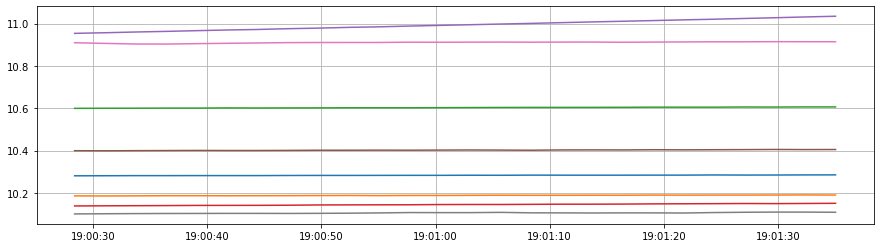

In [41]:
fig, ax = plt.subplots(1,1, figsize=(15,4))
for i in range(1,8+1):
    plt.plot(getattr(df, 'temperatureC%02d'%i))
plt.grid()

In [91]:
filename = '../ptg2m1m3/Camera Hexapod Motions in Time Domain G.xlsx'
sheetname = 'Day 297'
dougData = pd.read_excel(filename, sheet_name = sheetname, skiprows = 17,  nrows= 1609-18, usecols = 'AF:AK')

In [92]:
dougData

,dx.3,dy.3,dz.3,rx.3,ry.3,rz.3
0,-0.288482,-397.139605,280.174412,-0.010886,4.097463e-07,0.000015
1,-0.288482,-397.139605,280.174412,-0.010886,4.097463e-07,0.000015
2,-0.311661,-460.268167,287.218254,-0.012583,7.781584e-08,0.000016
3,-0.311661,-460.268167,287.218254,-0.012583,7.781584e-08,0.000016
4,-0.333079,-531.448175,292.575575,-0.014494,-3.238247e-07,0.000016
...,...,...,...,...,...,...
1586,0.144035,180.631195,94.952722,0.004753,2.168812e-06,0.000007
1587,0.144035,180.631195,94.952722,0.004753,2.168812e-06,0.000007
1588,0.143011,179.776599,95.437059,0.004730,2.168439e-06,0.000007
1589,0.143011,179.776599,95.437059,0.004730,2.168439e-06,0.000007


In [111]:
await printHexaPosition(camhex)
await printHexaUncompensatedAndCompensated(camhex)

Current Hexapod position
     -1.47    -461.12     287.35  -0.012608   0.000007   0.000005
Uncompensated position
      0.00       0.00       0.00      0.000000   0.000000   0.000000    2021-05-05 19:40:35.938602752
Compensated position
     -0.88    -460.28     287.21      -0.012583   0.000000   0.000000    2021-05-05 21:06:00.072892416


In [117]:
threshold_temperature = 28
check_time_interval = 60 #seconds
timeout_interval = 60

need_to_exit = False
while not need_to_exit:
    try:
        temp = await ess.tel_temperature8Ch.next(flush=True, timeout=timeout_interval)
        aa = [getattr(temp,'temperatureC%02d'%i) for i in range(1,8+1)]
        print(datetime.now(), ['%d: %.2f'%(i,aa[i]) for i in range(8)])
        if max(aa) > threshold_temperature:
            need_to_exit = True
            print('temperature getting too high: ', ['%d: %.2f'%(i,aa[i]) for i in range(8)])
        else:
            await asyncio.sleep(check_time_interval)
    except asyncio.exceptions.TimeoutError:
        need_to_exit = True
        print('Getting temperature timed out.')
await salobj.set_summary_state(camhex, salobj.State.STANDBY)

2021-05-05 21:45:01.445553 ['0: 11.04', '1: 10.78', '2: 11.25', '3: 10.71', '4: 11.68', '5: 11.02', '6: 11.37', '7: 10.56']
2021-05-05 21:46:02.794120 ['0: 11.04', '1: 10.78', '2: 11.25', '3: 10.71', '4: 11.68', '5: 11.02', '6: 11.37', '7: 10.56']
2021-05-05 21:47:04.127560 ['0: 11.05', '1: 10.78', '2: 11.25', '3: 10.72', '4: 11.67', '5: 11.03', '6: 11.36', '7: 10.56']
2021-05-05 21:48:05.460315 ['0: 11.05', '1: 10.79', '2: 11.26', '3: 10.72', '4: 11.67', '5: 11.03', '6: 11.37', '7: 10.56']
2021-05-05 21:49:06.809003 ['0: 11.05', '1: 10.79', '2: 11.26', '3: 10.72', '4: 11.67', '5: 11.04', '6: 11.36', '7: 10.56']
2021-05-05 21:50:08.142198 ['0: 11.05', '1: 10.79', '2: 11.26', '3: 10.72', '4: 11.67', '5: 11.05', '6: 11.35', '7: 10.57']
2021-05-05 21:51:09.475141 ['0: 11.05', '1: 10.79', '2: 11.27', '3: 10.72', '4: 11.66', '5: 11.05', '6: 11.36', '7: 10.57']
2021-05-05 21:52:10.824134 ['0: 11.05', '1: 10.80', '2: 11.28', '3: 10.72', '4: 11.66', '5: 11.06', '6: 11.36', '7: 10.57']
2021-05-

rotation DDS read queue is full (100 elements); data may be lost
motors DDS read queue is full (100 elements); data may be lost
electrical DDS read queue is full (100 elements); data may be lost
rotation DDS read queue is full (100 elements); data may be lost


2021-05-05 22:09:33.581125 ['0: 11.06', '1: 10.85', '2: 11.31', '3: 10.77', '4: 11.65', '5: 11.11', '6: 11.40', '7: 10.59']
2021-05-05 22:10:34.902833 ['0: 11.07', '1: 10.85', '2: 11.32', '3: 10.77', '4: 11.65', '5: 11.11', '6: 11.40', '7: 10.59']
2021-05-05 22:11:36.254497 ['0: 11.08', '1: 10.85', '2: 11.31', '3: 10.77', '4: 11.64', '5: 11.11', '6: 11.40', '7: 10.59']
2021-05-05 22:12:37.581922 ['0: 11.08', '1: 10.84', '2: 11.31', '3: 10.77', '4: 11.63', '5: 11.11', '6: 11.40', '7: 10.59']
2021-05-05 22:13:38.914654 ['0: 11.09', '1: 10.85', '2: 11.32', '3: 10.77', '4: 11.63', '5: 11.13', '6: 11.40', '7: 10.60']
2021-05-05 22:14:40.244672 ['0: 11.08', '1: 10.85', '2: 11.32', '3: 10.78', '4: 11.63', '5: 11.13', '6: 11.41', '7: 10.59']
2021-05-05 22:15:41.596316 ['0: 11.08', '1: 10.85', '2: 11.32', '3: 10.78', '4: 11.63', '5: 11.12', '6: 11.40', '7: 10.60']
2021-05-05 22:16:42.926417 ['0: 11.07', '1: 10.85', '2: 11.32', '3: 10.79', '4: 11.63', '5: 11.12', '6: 11.40', '7: 10.59']
2021-05-

motors DDS read queue is full (100 elements); data may be lost


2021-05-06 02:42:30.790319 ['0: 11.29', '1: 11.07', '2: 11.58', '3: 11.01', '4: 11.36', '5: 11.42', '6: 11.45', '7: 10.65']
2021-05-06 02:43:32.130102 ['0: 11.28', '1: 11.07', '2: 11.58', '3: 11.01', '4: 11.36', '5: 11.42', '6: 11.44', '7: 10.65']
2021-05-06 02:44:33.464267 ['0: 11.27', '1: 11.07', '2: 11.58', '3: 11.01', '4: 11.36', '5: 11.42', '6: 11.44', '7: 10.66']
2021-05-06 02:45:34.801082 ['0: 11.27', '1: 11.07', '2: 11.58', '3: 11.01', '4: 11.36', '5: 11.41', '6: 11.44', '7: 10.65']
2021-05-06 02:46:36.153652 ['0: 11.28', '1: 11.06', '2: 11.58', '3: 11.01', '4: 11.36', '5: 11.41', '6: 11.45', '7: 10.65']
2021-05-06 02:47:37.479366 ['0: 11.28', '1: 11.06', '2: 11.58', '3: 11.01', '4: 11.36', '5: 11.41', '6: 11.45', '7: 10.65']
2021-05-06 02:48:38.811762 ['0: 11.29', '1: 11.06', '2: 11.58', '3: 11.01', '4: 11.36', '5: 11.42', '6: 11.45', '7: 10.64']
2021-05-06 02:49:40.159354 ['0: 11.28', '1: 11.06', '2: 11.58', '3: 11.01', '4: 11.35', '5: 11.42', '6: 11.44', '7: 10.65']
2021-05-

powerSupplyData DDS read queue is full (100 elements); data may be lost
inclinometerData DDS read queue is full (100 elements); data may be lost
imsData DDS read queue is full (100 elements); data may be lost
hardpointMonitorData DDS read queue is full (100 elements); data may be lost
hardpointActuatorData DDS read queue is full (100 elements); data may be lost
forceActuatorData DDS read queue is full (100 elements); data may be lost
accelerometerData DDS read queue is full (100 elements); data may be lost
logMessage DDS read queue is full (100 elements); data may be lost
forceActuatorWarning DDS read queue is full (100 elements); data may be lost
appliedForces DDS read queue is full (100 elements); data may be lost
appliedElevationForces DDS read queue is full (100 elements); data may be lost
appliedCylinderForces DDS read queue is full (100 elements); data may be lost


2021-05-06 08:26:00.331668 ['0: 11.22', '1: 10.96', '2: 11.49', '3: 11.06', '4: 11.21', '5: 11.37', '6: 11.44', '7: 10.67']
2021-05-06 08:27:01.671925 ['0: 11.22', '1: 10.96', '2: 11.49', '3: 11.06', '4: 11.21', '5: 11.37', '6: 11.44', '7: 10.67']
2021-05-06 08:28:03.020647 ['0: 11.22', '1: 10.96', '2: 11.49', '3: 11.06', '4: 11.21', '5: 11.37', '6: 11.43', '7: 10.67']
2021-05-06 08:29:04.343769 ['0: 11.22', '1: 10.96', '2: 11.49', '3: 11.06', '4: 11.21', '5: 11.37', '6: 11.44', '7: 10.67']
2021-05-06 08:30:05.686472 ['0: 11.22', '1: 10.96', '2: 11.49', '3: 11.06', '4: 11.21', '5: 11.37', '6: 11.44', '7: 10.67']
2021-05-06 08:31:07.019858 ['0: 11.22', '1: 10.96', '2: 11.49', '3: 11.06', '4: 11.21', '5: 11.37', '6: 11.44', '7: 10.67']
2021-05-06 08:32:08.355981 ['0: 11.22', '1: 10.96', '2: 11.49', '3: 11.06', '4: 11.21', '5: 11.37', '6: 11.44', '7: 10.67']
2021-05-06 08:33:09.701071 ['0: 11.22', '1: 10.96', '2: 11.49', '3: 11.07', '4: 11.21', '5: 11.37', '6: 11.44', '7: 10.68']
2021-05-

CancelledError: 

In [ ]:
threshold_temperature = 28
timeout_interval = 60

need_to_exit = False
i_elevation = 0
while not need_to_exit:
    try:
        mount.evt_target.flush()
        #when it moves, we can wait for the next inPosition event. When stationary, this goes off randomly!!!
        camhex.evt_inPosition.flush()#this is very unreliable. Should skip waiting for any events, just sleep(2.0)
        camhex.evt_compensationOffset.flush()
        new_elevation = await mount.evt_target.next(flush=False, timeout=60.)
        if 1: #np.mod(i_elevation, 10)==0:
            a = await camhex.evt_compensationOffset.next(flush=False, timeout=10.)
            await camhex.evt_inPosition.next(flush=False, timeout=10.)
            print('----------move#%d, elevation = %.2f'%(i_elevation, new_elevation.elevation))
            print('mount elevation = ', a.elevation)
            print('mount azimth = ', a.azimuth)
            print('rotator angle = ', a.rotation)
            print('? temperature = ', a.temperature)
            print('x,y,z,u,v,w = ', a.x, a.y, a.z, a.u, a.v, a.w, pd.to_datetime(a.private_sndStamp, unit='s'))
            await printHexaPosition(camhex)
            await printHexaUncompensatedAndCompensated(camhex)
            print([dougData['%s.3'%j][i_elevation] for j in ['dx','dy','dz','rx','ry','rz']])
            pos = await camhex.tel_application.next(flush=True, timeout=10.)
            for i, j in enumerate(['dx','dy','dz']):
                print('diff in %s = %.2f '%(j, pos.position[i] - dougData['%s.3'%j][i_elevation]), end = ' ')
            for i, j in enumerate(['rx','ry','rz']):
                print('diff in %s = %.6f '%(j, pos.position[i+3] - dougData['%s.3'%j][i_elevation]), end = ' ')
            print('')
        temp = await ess.tel_temperature8Ch.next(flush=True, timeout=timeout_interval)
        aa = [getattr(temp,'temperatureC%02d'%i) for i in range(1,8+1)]
        print(datetime.now(), ['%d: %.2f'%(i,aa[i]) for i in range(8)])
        if max(aa) > threshold_temperature:
            need_to_exit = True
            print('temperature getting too high: ', ['%d: %.2f'%(i,aa[i]) for i in range(8)])
    except asyncio.exceptions.TimeoutError:
        need_to_exit = True
        print('Getting temperature timed out.')
    i_elevation += 1
await salobj.set_summary_state(camhex, salobj.State.STANDBY)

In [106]:
import yaml
LUTfile = '%s/notebooks/ts_config_mttcs/MTHexapod/v1/default.yaml'%(os.environ["HOME"])
with open(LUTfile, 'r') as stream:
    aa = yaml.safe_load(stream)
elevCoeff = aa['camera_config']['elevation_coeffs']
tCoeff = aa['camera_config']['temperature_coeffs']

def printPredictedComp(elevCoeff, elev):
    '''
    This function deals with the elevation component of the LUT only, for now.
    We will add temperature, azimuth, and rotator angle when they are implemented.
    '''
    pred = []
    print('Predicted LUT compensation:')
    for i in range(6):
        coeff = elevCoeff[i] #starts with C0
        mypoly = np.polynomial.Polynomial(coeff)
        #mypoly = np.poly1d(coeff[::-1]) #if you use poly1d, be aware: it needs C5 first
        pred.append(mypoly(elev))
    print(" ".join(f"{p:10.2f}" for p in pred))

In [107]:
printPredictedComp(elevCoeff, 78.84)

Predicted LUT compensation:
     -0.86    -397.17     280.17      -0.01       0.00       0.00


In [70]:
await camhex.cmd_move.set_start(x=0,y=0,z=100, u=0,v=0,w=0,sync=True)

In [86]:
await printHexaPosition(camhex)
await printHexaUncompensatedAndCompensated(camhex)

Current Hexapod position
     -0.81    -418.03     282.82  -0.011441  -0.000000  -0.000003
Uncompensated position
      0.00       0.00       0.00      0.000000   0.000000   0.000000    2021-05-05 19:40:35.938602752
Compensated position
     -0.87    -418.87     282.84      -0.011470   0.000000   0.000000    2021-05-05 19:50:16.000826368


In [85]:
a = await camhex.evt_compensationOffset.aget(timeout=10.)
print('mount elevation = ', a.elevation)
print('mount azimth = ', a.azimuth)
print('rotator angle = ', a.rotation)
print('? temperature = ', a.temperature)
print('x,y,z,u,v,w = ', a.x, a.y, a.z, a.u, a.v, a.w, pd.to_datetime(a.private_sndStamp, unit='s'))

mount elevation =  84.730145
mount azimth =  0.0
rotator angle =  0.0
? temperature =  0.0
x,y,z,u,v,w =  -0.902466858359046 -531.4587652349884 292.5674726823953 -0.014494094791019409 0.0 0.0 2021-05-05 19:49:36.893944576


In [65]:
lutMode = await camhex.evt_compensationMode.aget(timeout=10)
print("compsensation mode enabled?",lutMode.enabled, pd.to_datetime(lutMode.private_sndStamp, unit='s'))

compsensation mode enabled? True 2021-05-05 18:24:40.875696384


### endurance test with compensation mode off

In [121]:
await camhex.cmd_setCompensationMode.set_start(enable=0, timeout=10)
lutMode = await camhex.evt_compensationMode.next(flush=False, timeout=10)
print("compsensation mode enabled?",lutMode.enabled, pd.to_datetime(lutMode.private_sndStamp, unit='s'))

compsensation mode enabled? False 2021-05-06 14:53:46.946983936


In [144]:
await camhex.cmd_move.set_start(x=0,y=0,z=0, u=0,v=0,w=0,sync=True)

In [129]:
await printHexaPosition(camhex)
await printHexaUncompensatedAndCompensated(camhex)

Current Hexapod position
     -0.69      -0.24      -0.27  -0.000004   0.000013  -0.000000
Uncompensated position
      0.00       0.00       0.00      0.000000   0.000000   0.000000    2021-05-06 16:14:28.789397504
Compensated position
      0.00       0.00       0.00       0.000000   0.000000   0.000000    2021-05-06 16:14:28.789563904


In [134]:
filename = '../ptg2m1m3/Camera Hexapod Motions in Time Domain G.xlsx'
sheetname = 'Day 297'
dougData_time = pd.read_excel(filename, sheet_name = sheetname, skiprows = 17,  nrows= 1609-18, usecols = 'A:B')
dougData = pd.read_excel(filename, sheet_name = sheetname, skiprows = 17,  nrows= 1609-18, usecols = 'AF:AK')

In [145]:
number_of_moves = len(dougData)
#number_of_moves = 5 #test run
for i in range(number_of_moves):
    hh = np.floor(dougData_time['TimeSeconds'][i]/3600)
    mm = np.floor((dougData_time['TimeSeconds'][i]-3600*hh)/60)
    ss = dougData_time['TimeSeconds'][i]-3600*hh - 60*mm
    print('Move #%4d, time elapsed: %2d hours, %2d minutes, %2d seconds, elevation= %5.2f deg'%(
        i+1, hh, mm, ss, dougData_time['Elevation(deg)'][i]), end = ' ')
    print(['%.0f'%dougData['d%s.3'%j][i] for j in ['x','y','z']], end = ' ')
    print(['%.6f'%dougData['r%s.3'%j][i] for j in ['x','y','z']])
    await camhex.cmd_move.set_start(x=dougData['dx.3'][i],
                                    y=dougData['dy.3'][i],
                                    z=dougData['dz.3'][i],
                                    u=dougData['rx.3'][i],
                                    v=dougData['ry.3'][i],
                                    w=dougData['rz.3'][i],sync=True)
    temp = await ess.tel_temperature8Ch.next(flush=True, timeout=timeout_interval)
    aa = [getattr(temp,'temperatureC%02d'%i) for i in range(1,8+1)]
    print(datetime.now(), ['%d: %.2f'%(i,aa[i]) for i in range(8)])
    if max(aa) > threshold_temperature:
        print('temperature getting too high: ', ['%d: %.2f'%(i,aa[i]) for i in range(8)])
        break
    if i < number_of_moves - 1:
        sleep_time = dougData_time['TimeSeconds'][i+1] - dougData_time['TimeSeconds'][i]
        await asyncio.sleep(sleep_time)

Move #   1, time elapsed:  0 hours,  0 minutes,  0 seconds, elevation= 78.84 deg ['-0', '-397', '280'] ['-0.010886', '0.000000', '0.000015']
2021-05-06 17:10:48.013325 ['0: 12.32', '1: 12.09', '2: 12.37', '3: 11.82', '4: 12.02', '5: 12.42', '6: 12.51', '7: 11.78']
Move #   2, time elapsed:  0 hours,  0 minutes, 34 seconds, elevation= 78.84 deg ['-0', '-397', '280'] ['-0.010886', '0.000000', '0.000015']
2021-05-06 17:11:22.695136 ['0: 12.32', '1: 12.09', '2: 12.38', '3: 11.84', '4: 12.03', '5: 12.43', '6: 12.51', '7: 11.78']
Move #   3, time elapsed:  0 hours,  0 minutes, 38 seconds, elevation= 81.62 deg ['-0', '-460', '287'] ['-0.012583', '0.000000', '0.000016']
2021-05-06 17:11:28.021975 ['0: 12.33', '1: 12.09', '2: 12.38', '3: 11.84', '4: 12.03', '5: 12.43', '6: 12.51', '7: 11.78']
Move #   4, time elapsed:  0 hours,  1 minutes, 12 seconds, elevation= 81.62 deg ['-0', '-460', '287'] ['-0.012583', '0.000000', '0.000016']
2021-05-06 17:12:02.688357 ['0: 12.33', '1: 12.10', '2: 12.39', 

In [ ]:
            for i, j in enumerate(['dx','dy','dz']):
                print('diff in %s = %.2f '%(j, pos.position[i] - dougData['%s.3'%j][i_elevation]), end = ' ')
            for i, j in enumerate(['rx','ry','rz']):
                print('diff in %s = %.6f '%(j, pos.position[i+3] - dougData['%s.3'%j][i_elevation]), end = ' ')

### Close up

In [ ]:
await salobj.set_summary_state(camhex, salobj.State.STANDBY)

### Check if the telescope is in tracking mode. If yes, need to stop stacking. 
The alternative is to check "MT Mount status" dash board on Chronograf. Make sure there are three "False".

In [ ]:
mountStatus = await mount.evt_axesInPosition.aget(timeout=5.)
rotStatus = await rot.evt_inPosition.aget(timeout=5.)
trackingStatus = mountStatus.elevation and mountStatus.azimuth and rotStatus.inPosition
print('Are we tracking?', trackingStatus)

In [ ]:
await ptg.cmd_stopTracking.set_start(timeout=5.)